In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
# Regression
import statsmodels.api as sm
# LASSO
from sklearn import model_selection
from sklearn.linear_model import Lasso
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# XGBoost
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
# HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

import warnings
warnings.simplefilter(action='ignore')

In [62]:
data = pd.read_csv('NQ.csv')
factors = pd.read_csv('factor.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data

,y,a1,a2,b1,b2,b3,b4,b5,b6,b7,...,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-09,0.000555,0.675009,0.67,2.029210,1.61,1.354201,0.94,2.40,18.70,80.56,...,-1.25,-2.029728,-1.92,1.65,72.17,38.37,-1.579,13.25,-3.08,-0.02
2020-01-10,-0.006665,0.012606,0.81,0.779468,2.12,0.766862,1.31,1.37,26.23,84.60,...,-0.80,-1.952923,-1.61,3.25,28.33,35.54,-1.813,13.51,-3.73,-0.95
2020-01-13,0.007542,-0.585729,-0.27,-0.086929,0.23,0.498800,0.50,1.42,-15.69,84.98,...,-2.30,-1.453885,-2.03,2.26,-1.09,28.82,-2.286,14.27,-5.64,-3.27
2020-01-14,-0.002971,0.653482,1.04,1.707098,2.14,1.053616,1.10,1.87,-14.73,88.06,...,0.66,-0.266841,-0.38,1.37,-51.36,32.75,-2.420,14.98,-4.62,-2.71
2020-01-15,0.001105,-0.207969,-0.24,-1.269340,-1.35,-1.061371,-1.11,1.73,35.38,76.77,...,2.32,2.254327,2.56,2.45,46.02,44.84,-2.038,14.63,-2.29,-0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,-0.000209,-0.984979,-0.93,-0.657744,-0.48,0.327235,0.45,2.86,-14.12,40.59,...,-1.37,-0.337247,-0.44,5.38,-11.75,34.64,-2.828,24.21,-9.41,-1.07
2024-07-29,-0.005282,0.149617,1.03,-0.338363,0.22,-0.487980,-0.81,1.60,-18.87,41.68,...,1.59,-1.367858,0.56,2.41,-31.09,38.36,-2.810,24.55,-7.78,0.26
2024-07-30,-0.016868,-0.425302,0.07,0.589971,0.13,1.015273,0.06,1.63,-13.03,42.38,...,-0.93,-0.758752,-1.00,3.89,-20.37,36.97,-2.702,24.56,-8.35,-0.96


In [63]:
# 用前一期填上空值
# df_fill = data.fillna(method='ffill')
df_fill = data.dropna()

df_features = df_fill.iloc[:,1:]
df_features = df_features.pct_change().dropna()
df_features.replace([np.inf,-np.inf],np.nan,inplace=True)
df_features = df_features.fillna(method='ffill')

df_clean = df_features.copy()
df_clean['y'] = df_fill['y']

df_dir = df_clean.copy()
for i in df_dir.columns:
    df_dir[i] = np.where(df_dir[i]<0,-1,1)

In [64]:
def draw_predict_perform(df):
    df_sorted = df.sort_values('predict',ascending=True)
    df_sorted['decile'] = pd.qcut(df_sorted['predict'],10,labels=False)
    grouped = df_sorted[['y','predict','decile']].groupby('decile').mean()
    print(grouped)
    plt.bar(grouped.index,grouped['y'])
    plt.grid(True,alpha=0.4)
def confusion_matrix(df):
    df['predict_signal'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,np.nan))
    df['real_signal'] = np.where(df['y']>0,1,np.where(df['y']<0,-1,np.nan))
    df['accuracy_value'] = np.where(abs(df['predict']-df['y'])<0.01,1,-1)
    df['accuracy'] = np.where((df['predict_signal']==1)&(df['real_signal']==1),'TP',np.where((df['predict_signal']==1)&(df['real_signal']==-1),'FP',np.where((df['predict_signal']==-1)&(df['real_signal']==1),'FN','TN')))
    accuracy_matrix = pd.DataFrame(columns = ['Real Yes','Real No'],index = ['Predict Yes','Predict No'])
    tp = df[df['accuracy']=='TP']
    fp = df[df['accuracy']=='FP']
    fn = df[df['accuracy']=='FN']
    tn = df[df['accuracy']=='TN']
    accuracy_matrix.loc['Predict Yes','Real Yes'] = len(tp)/len(df)
    accuracy_matrix.loc['Predict Yes','Real No'] = len(fp)/len(df)
    accuracy_matrix.loc['Predict No','Real Yes'] = len(fn)/len(df)
    accuracy_matrix.loc['Predict No','Real No'] = len(tn)/len(df)
    accuracy_matrix_values = len(df[df['accuracy_value']==1])/len(df)


    print(f'Prevaience: {(len(tp)+len(fn))/len(df)}')
    print(f'Accurancy:{(len(tp)+len(tn))/len(df)}')
    print(f'Precision:{len(tp)/(len(tp)+len(fp))}')
    print(f'Recall:{len(tp)/(len(tp)+len(fn))}')
    print(f'F1 Score: {2/(1/(len(tp)/(len(tp)+len(fp)))+1/(len(tp)/(len(tp)+len(fn))))}')
    print(f'Accurancy of No : {len(tn)/(len(fp)+len(tn))}')
    print(f'---accuraccy matrix of values---------------')
    print(f'{accuracy_matrix_values}')

    return accuracy_matrix
def draw_distribution(df):
    plt.ylabel('Real Return')
    plt.xlabel('Predict Return')
    plt.scatter(x = df['predict'],y =df['y'])
    plt.axhline(0,linestyle='--',color='black')
    plt.axvline(0,linestyle='--',color='black')
    df = df.dropna()
    model = sm.OLS(df['y'],sm.add_constant(df['predict'])).fit()
    print(model.params)
    try:
        plt.plot(df['predict'],df['predict']*model.params['predict']+model.params['const'],color='r')
    except:
        plt.plot(df['predict'],df['predict']*model.params['predict'],color='r')

In [65]:
factors

,lead_factor,lead_factors_days,lead_factor_dir,lead_factor_dir_days,k_means,k_means_dir,k_means_y,k_means_y_dir,low_corr,low_corr_dir,similar_dir
0,e8,139.0,g8,139.0,a2,a2,a2,b8,d3,p4,a2
1,h6,136.0,h10,136.0,b3,b3,b1,c8,p4,i2,b1
2,p10,218.0,i11,218.0,c2,b4,b2,d8,i2,f8,b2
3,m8,162.0,h7,162.0,c3,b5,b4,d10,f8,p5,b3
4,f3,91.0,c8,91.0,c6,b7,b5,e8,p5,l6,b4
...,...,...,...,...,...,...,...,...,...,...,...
142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f3,NaN,NaN
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i9,NaN,NaN
144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,h5,NaN,NaN
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f4,NaN,NaN


In [66]:
lead_factor = factors['lead_factor'].dropna().to_list()
lead_factor_days = factors['lead_factors_days'].dropna().to_list()
lead_factor_dir = factors['lead_factor_dir'].dropna().to_list()
lead_factor_dir_days = factors['lead_factor_dir_days'].dropna().to_list()
k_means_pick = factors['k_means'].dropna().to_list()
k_means_dir = factors['k_means_dir'].dropna().to_list()
k_means_y = factors['k_means_y'].dropna().to_list()
k_means_y.remove('y')
k_means_y_dir = factors['k_means_y_dir'].dropna().to_list()
k_means_y_dir.remove('y')
low_corr = factors['low_corr'].dropna().to_list()
low_corr_dir = factors['low_corr_dir'].dropna().to_list()

## **------Select Factor-----------**

In [67]:
select = lead_factor_dir
print(len(select))

10


In [68]:
df_normal = df_clean[abs(df_clean['y'])<=0.02]
df_abnormal = df_clean[abs(df_clean['y'])>0.02]

In [69]:
df = df_clean[select]
df_normal = df_normal[select]
df_abnormal = df_abnormal[select]

## **Abnormal**

#### XGBoost

In [70]:
# df_abnormal = (df_abnormal - df_abnormal.mean())/df_abnormal.std()
# ratio = 0.7
# if select == lead_factor:
#     for i in range(len(lead_factor)):
#         item = lead_factor[i]
#         days = lead_factor_days[i]
#         df_abnormal[item] = df_abnormal[item].shift(int(days))
# elif select == lead_factor_dir:
#     for i in range(len(lead_factor_dir)):
#         item = lead_factor_dir[i]
#         days = lead_factor_dir_days[i]
#         df_abnormal[item] = df_abnormal[item].shift(int(days))
# df_abnormal['y'] = df_clean['y']
# df_abnormal = df_abnormal.dropna()
# df_train = df_abnormal.iloc[:int(len(df_abnormal)*ratio)]
# df_test = df_abnormal.iloc[int(len(df_abnormal)*ratio):]
# x_train = df_train[select]
# x_test = df_test[select]

# y_train = df_train['y']
# y_test = df_test['y']

# xgboostModel = XGBRegressor(max_depth = 60,n_estimators=300, learning_rate=2).fit(x_train,y_train)
# predicted = xgboostModel.predict(x_test)
# df_boost = pd.DataFrame({'y':y_test,'predict':predicted})
# draw_distribution(df_boost)
# confusion_matrix(df_boost)

#### HistBoost

In [71]:
# df_abnormal = (df_abnormal - df_abnormal.mean())/df_abnormal.std()
# ratio = 0.7
# if select == lead_factor:
#     for i in range(len(lead_factor)):
#         item = lead_factor[i]
#         days = lead_factor_days[i]
#         df_abnormal[item] = df_abnormal[item].shift(int(days))
# elif select == lead_factor_dir:
#     for i in range(len(lead_factor_dir)):
#         item = lead_factor_dir[i]
#         days = lead_factor_dir_days[i]
#         df_abnormal[item] = df_abnormal[item].shift(int(days))
# df_abnormal['y'] = (df_clean['y'] - df_clean['y'].mean())/df_clean['y'].std()
# df_abnormal = df_abnormal.dropna()
# df_abnormal
# df_train = df_abnormal.iloc[:int(len(df_abnormal)*ratio)]
# df_test = df_abnormal.iloc[int(len(df_abnormal)*ratio):]
# # select.remove('y')
# x_train = df_train[select]
# x_test = df_test[select]

# y_train = df_train['y']
# y_test = df_test['y']
# print(len(df_train),len(df_test))
# model = HistGradientBoostingRegressor(max_depth = 30, learning_rate=2).fit(x_train,y_train)
# predicted = model.predict(x_test)
# df_histboost = pd.DataFrame({'y':y_test,'predict':predicted})
# draw_distribution(df_histboost)
# confusion_matrix(df_histboost)

####  Regression

In [72]:
# ## value
# if select == lead_factor:
#     for i in range(len(lead_factor)):
#         item = lead_factor[i]
#         days = lead_factor_days[i]
#         df_abnormal[item] = df_abnormal[item].shift(int(days))
# elif select == lead_factor_dir:
#     for i in range(len(lead_factor_dir)):
#         item = lead_factor_dir[i]
#         days = lead_factor_dir_days[i]
#         df_abnormal[item] = df_abnormal[item].shift(int(days))
# df_abnormal['y'] = df_clean['y']
# df_reg = df_abnormal.dropna()
# time_units = 60

# for i in range(len(df_reg)-time_units):
#     today = df_reg.iloc[i+time_units].name
#     next_day = df_reg.loc[today:].head(2).index[-1]
#     ## 固定取值    
#     # duration = df_reg.iloc[i:i+time_units]
#     ## 累加取值
#     duration = df_reg.loc[:today]
#     # duration = (duration - duration.mean())/duration.std()

#     Y = duration['y']
#     X = duration[select]
#     model = sm.OLS(Y,sm.add_constant(X)).fit()
#     df_reg.loc[next_day,'R-Square'] = model.rsquared*100
#     predict=0
#     try:
#         df_reg.loc[next_day,'const'] = model.params.const
#         predict+=df_reg.loc[next_day,'const']
#     except:
#         df_reg.loc[next_day,'const'] = np.nan
    
#     for j in select:
#         df_reg.loc[next_day,j+' coef'] = model.params[j]
#         predict += (df_reg.loc[next_day,j])*df_reg.loc[next_day,j+' coef']
#         # predict += (duration[j].mean())*df_reg.loc[next_day,j+'coef']
#     df_reg.loc[next_day,'predict'] = predict 
# df_reg
# draw_distribution(df_reg)
# confusion_matrix(df_reg)

#### LSTM

In [73]:
# ## value
# ratio = 0.7
# df = df_abnormal.copy()
# # if select == lead_factor:
# #     for i in range(len(lead_factor)):
# #         item = lead_factor[i]
# #         days = lead_factor_days[i]
# #         df[item] = df[item].shift(int(days))
# # elif select == lead_factor_dir:
# #     for i in range(len(lead_factor_dir)):
# #         item = lead_factor_dir[i]
# #         days = lead_factor_dir_days[i]
# #         df[item] = df[item].shift(int(days))
# df['y'] = df_clean['y']
# df = df.dropna()
# df_train = df.iloc[:int(len(df)*ratio)]
# df_test = df.iloc[int(len(df)*ratio):]
# x_train = np.array(df_train[select])
# x_test = np.array(df_test[select])

# y_train = np.array(df_train['y'])
# y_test = np.array(df_test['y'])
# print(f'n of x train :{x_train.shape}')
# print(f'n of y train :{y_train.shape}')
# print(f'n of x train :{x_test.shape}')
# print(f'n of y train :{y_test.shape}')

# FullData = df[select]
# # FullData.replace([np.inf, -np.inf], np.nan, inplace=True) 
# # FullData.dropna(inplace=True) 
# FullDataY = df['y'].values
# FullData = FullData.values

# # sc = StandardScaler()
# sc=MinMaxScaler()
# DataScaler = sc.fit(FullData)
# X=DataScaler.transform(FullData)
# DataScalerY = sc.fit(FullDataY.reshape(-1, 1))
# Y=DataScalerY.transform(FullDataY.reshape(-1, 1))
# # X.replace([np.inf, -np.inf], np.nan, inplace=True) 
# # X.dropna(inplace=True) 
 
# print('### After Normalization ###')
# print(X.shape)
# print(Y.shape)

# X_samples = list()
# y_samples = list()
 
# NumerOfRows = len(X)
# TimeSteps=5  # next day's Price Prediction is based on last how many past day's prices
 
# # Iterate thru the values to create combinations
# for i in range(TimeSteps , NumerOfRows , 1):
#     x_sample = X[i-TimeSteps:i]
#     y_sample = Y[i]
#     X_samples.append(x_sample)
#     y_samples.append(y_sample)

# # Reshape the Input as a 3D (number of samples, Time Steps, Features)
# X_data=np.array(X_samples)
# X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], X.shape[1])
# print('\n#### Input Data shape ####')
# print(X_data.shape)
 
# y_data=np.array(y_samples)
# y_data=y_data.reshape(y_data.shape[0], 1)
# print('\n#### Output Data shape ####')
# print(y_data.shape)

# TestingRecords=0.3*len(df)
# X_train=X_data[:-TestingRecords]
# X_test=X_data[-TestingRecords:]
# y_train=y_data[:-TestingRecords]
# y_test=y_data[-TestingRecords:]
 
# # Printing the shape of training and testing
# print('\n#### Training Data shape ####')
# print(X_train.shape)
# print(y_train.shape)
# print('\n#### Testing Data shape ####')
# print(X_test.shape)
# print(y_test.shape)

# # Defining Input shapes for LSTM
# TimeSteps=X_train.shape[1]
# TotalFeatures=X_train.shape[2]
# print("Number of TimeSteps:", TimeSteps)
# print("Number of Features:", TotalFeatures)
 
# # Initialising the RNN
# regressor = Sequential()
# regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
# regressor.add(Dense(units = 1))
# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

# TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
# TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
# print(len(TrainPredictions),len(TestPredictions))
 
# FullDataPredictions=np.append(TrainPredictions, TestPredictions)
# FullDataOrig=FullDataY[TimeSteps:]

# plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted')
# plt.plot(FullDataOrig , color = 'lightblue', label = 'Original')
 
 
# plt.title('Predictions')
# plt.xlabel('Trading Date')
# plt.ylabel('pct')
# plt.legend()
# fig=plt.gcf()
# fig.set_figwidth(20)
# fig.set_figheight(8)
# plt.show()

# df_lstm = pd.DataFrame({'y':[i for i in FullDataY[-300:].tolist()],'predict':[i[0] for i in TestPredictions.tolist()]})
# draw_distribution(df_lstm)
# confusion_matrix(df_lstm)

## **Normal**

#### XGBoost

In [74]:
# df_normal = (df_normal - df_normal.mean())/df_normal.std()
# ratio = 0.7
# if select == lead_factor:
#     for i in range(len(lead_factor)):
#         item = lead_factor[i]
#         days = lead_factor_days[i]
#         df_normal[item] = df_normal[item].shift(int(days))
# elif select == lead_factor_dir:
#     for i in range(len(lead_factor_dir)):
#         item = lead_factor_dir[i]
#         days = lead_factor_dir_days[i]
#         df_normal[item] = df_normal[item].shift(int(days))
# df_normal['y'] = df_clean['y']
# df_normal = df_normal.dropna()
# df_train = df_normal.iloc[:int(len(df_normal)*ratio)]
# df_test = df_normal.iloc[int(len(df_normal)*ratio):]
# x_train = df_train[select]
# x_test = df_test[select]

# y_train = df_train['y']
# y_test = df_test['y']

# xgboostModel1 = XGBRegressor(max_depth = 25,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted1 = xgboostModel1.predict(x_test)
# xgboostModel2 = XGBRegressor(max_depth = 15,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted2 = xgboostModel2.predict(x_test)
# xgboostModel3 = XGBRegressor(max_depth = 5,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted3 = xgboostModel3.predict(x_test)
# xgboostModel4 = XGBRegressor(max_depth = 60,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted4 = xgboostModel4.predict(x_test)
# xgboostModel5 = XGBRegressor(max_depth = 6,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted5 = xgboostModel5.predict(x_test)
# predicted = (predicted1+predicted2+predicted3+predicted4+predicted5)/5
# df_boost = pd.DataFrame({'y':y_test,'predict':predicted})
# draw_distribution(df_boost)
# confusion_matrix(df_boost)


#### HistBoost

In [75]:
# df_normal = (df_normal - df_normal.mean())/df_normal.std()
# ratio = 0.7
# # if select == lead_factor:
# #     for i in range(len(lead_factor)):
# #         item = lead_factor[i]
# #         days = lead_factor_days[i]
# #         df_normal[item] = df_normal[item].shift(int(days))
# # elif select == lead_factor_dir:
# #     for i in range(len(lead_factor_dir)):
# #         item = lead_factor_dir[i]
# #         days = lead_factor_dir_days[i]
# #         df_normal[item] = df_normal[item].shift(int(days))
# df_normal['y'] = (df_clean['y'] - df_clean['y'].mean())/df_clean['y'].std()
# df_normal = df_normal.dropna()
# df_train = df_normal.iloc[:int(len(df_normal)*ratio)]
# df_test = df_normal.iloc[int(len(df_normal)*ratio):]
# # select.remove('y')
# x_train = df_train[select]
# x_test = df_test[select]

# y_train = df_train['y']
# y_test = df_test['y']

# model = HistGradientBoostingRegressor(max_depth = 30, learning_rate=2).fit(x_train,y_train)
# predicted = model.predict(x_test)
# df_histboost = pd.DataFrame({'y':y_test,'predict':predicted})
# draw_distribution(df_histboost)
# confusion_matrix(df_histboost)

#### Regression

const      0.000843
predict    0.009454
dtype: float64
Prevaience: 0.5112582781456954
Accurancy:0.5695364238410596
Precision:0.5478806907378336
Recall:0.9041450777202072
F1 Score: 0.6823069403714564
Accurancy of No : 0.21951219512195122
---accuraccy matrix of values---------------
0.6317880794701987


,Real Yes,Real No
Predict Yes,0.462252,0.381457
Predict No,0.049007,0.107285


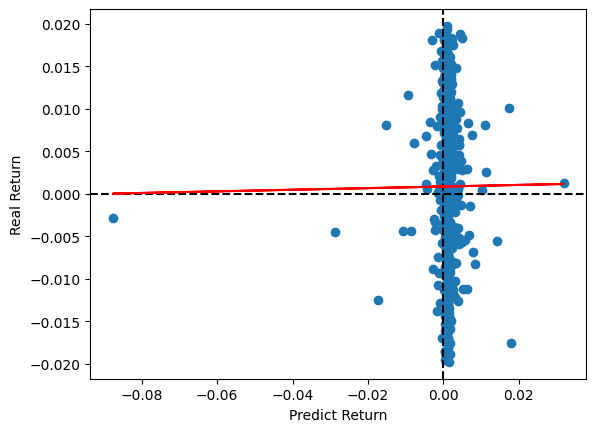

In [76]:
## value
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df_normal[item] = df_normal[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df_normal[item] = df_normal[item].shift(int(days))
df_normal['y'] = df_clean['y']
df_reg = df_normal.dropna()
time_units = 60

for i in range(len(df_reg)-time_units):
    today = df_reg.iloc[i+time_units].name
    next_day = df_reg.loc[today:].head(2).index[-1]
    ## 固定取值    
    # duration = df_reg.iloc[i:i+time_units]
    ## 累加取值
    duration = df_reg.loc[:today]
    # duration = (duration - duration.mean())/duration.std()

    Y = duration['y']
    X = duration[select]
    model = sm.OLS(Y,sm.add_constant(X)).fit()
    df_reg.loc[next_day,'R-Square'] = model.rsquared*100
    predict=0
    try:
        df_reg.loc[next_day,'const'] = model.params.const
        predict+=df_reg.loc[next_day,'const']
    except:
        df_reg.loc[next_day,'const'] = np.nan
    
    for j in select:
        df_reg.loc[next_day,j+' coef'] = model.params[j]
        predict += (df_reg.loc[next_day,j])*df_reg.loc[next_day,j+' coef']
        # predict += (duration[j].mean())*df_reg.loc[next_day,j+'coef']
    df_reg.loc[next_day,'predict'] = predict 
df_reg
draw_distribution(df_reg)
confusion_matrix(df_reg)

#### LSTM

In [77]:
# ## value
# ratio = 0.7
# df = df_normal.copy()
# if select == lead_factor:
#     for i in range(len(lead_factor)):
#         item = lead_factor[i]
#         days = lead_factor_days[i]
#         df[item] = df[item].shift(int(days))
# elif select == lead_factor_dir:
#     for i in range(len(lead_factor_dir)):
#         item = lead_factor_dir[i]
#         days = lead_factor_dir_days[i]
#         df[item] = df[item].shift(int(days))
# df['y'] = df_clean['y']
# df = df.dropna()
# df_train = df.iloc[:int(len(df)*ratio)]
# df_test = df.iloc[int(len(df)*ratio):]
# x_train = np.array(df_train[select])
# x_test = np.array(df_test[select])

# y_train = np.array(df_train['y'])
# y_test = np.array(df_test['y'])
# print(f'n of x train :{x_train.shape}')
# print(f'n of y train :{y_train.shape}')
# print(f'n of x train :{x_test.shape}')
# print(f'n of y train :{y_test.shape}')

# FullData = df[select]
# # FullData.replace([np.inf, -np.inf], np.nan, inplace=True) 
# # FullData.dropna(inplace=True) 
# FullDataY = df['y'].values
# FullData = FullData.values

# # sc = StandardScaler()
# sc=MinMaxScaler()
# DataScaler = sc.fit(FullData)
# X=DataScaler.transform(FullData)
# DataScalerY = sc.fit(FullDataY.reshape(-1, 1))
# Y=DataScalerY.transform(FullDataY.reshape(-1, 1))
# # X.replace([np.inf, -np.inf], np.nan, inplace=True) 
# # X.dropna(inplace=True) 
 
# print('### After Normalization ###')
# print(X.shape)
# print(Y.shape)

# X_samples = list()
# y_samples = list()
 
# NumerOfRows = len(X)
# TimeSteps=60  # next day's Price Prediction is based on last how many past day's prices
 
# # Iterate thru the values to create combinations
# for i in range(TimeSteps , NumerOfRows , 1):
#     x_sample = X[i-TimeSteps:i]
#     y_sample = Y[i]
#     X_samples.append(x_sample)
#     y_samples.append(y_sample)

# # Reshape the Input as a 3D (number of samples, Time Steps, Features)
# X_data=np.array(X_samples)
# X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], X.shape[1])
# print('\n#### Input Data shape ####')
# print(X_data.shape)
 
# y_data=np.array(y_samples)
# y_data=y_data.reshape(y_data.shape[0], 1)
# print('\n#### Output Data shape ####')
# print(y_data.shape)

# TestingRecords=300
# X_train=X_data[:-TestingRecords]
# X_test=X_data[-TestingRecords:]
# y_train=y_data[:-TestingRecords]
# y_test=y_data[-TestingRecords:]
 
# # Printing the shape of training and testing
# print('\n#### Training Data shape ####')
# print(X_train.shape)
# print(y_train.shape)
# print('\n#### Testing Data shape ####')
# print(X_test.shape)
# print(y_test.shape)

# # Defining Input shapes for LSTM
# TimeSteps=X_train.shape[1]
# TotalFeatures=X_train.shape[2]
# print("Number of TimeSteps:", TimeSteps)
# print("Number of Features:", TotalFeatures)
 
# # Initialising the RNN
# regressor = Sequential()
# regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
# regressor.add(Dense(units = 1))
# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

# TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
# TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
# print(len(TrainPredictions),len(TestPredictions))
 
# FullDataPredictions=np.append(TrainPredictions, TestPredictions)
# FullDataOrig=FullDataY[TimeSteps:]

# plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted')
# plt.plot(FullDataOrig , color = 'lightblue', label = 'Original')
 
 
# plt.title('Predictions')
# plt.xlabel('Trading Date')
# plt.ylabel('pct')
# plt.legend()
# fig=plt.gcf()
# fig.set_figwidth(20)
# fig.set_figheight(8)
# plt.show()

# df_lstm = pd.DataFrame({'y':[i for i in FullDataY[-300:].tolist()],'predict':[i[0] for i in TestPredictions.tolist()]})
# draw_distribution(df_lstm)
# confusion_matrix(df_lstm)

## **All**

#### HistBoost

In [78]:
## value
# df = (df_clean - df_clean.mean())/df_clean.std()
# ratio = 0.7
# if select == lead_factor:
#     for i in range(len(lead_factor)):
#         item = lead_factor[i]
#         days = lead_factor_days[i]
#         df[item] = df[item].shift(int(days))
# elif select == lead_factor_dir:
#     for i in range(len(lead_factor_dir)):
#         item = lead_factor_dir[i]
#         days = lead_factor_dir_days[i]
#         df[item] = df[item].shift(int(days))
# df['y'] = (df_clean['y'] - df_clean['y'].mean())/df_clean['y'].std()
# df = df.dropna()
# df_train = df.iloc[:int(len(df)*ratio)]
# df_test = df.iloc[int(len(df)*ratio):]
# # select.remove('y')
# x_train = df_train[select]
# x_test = df_test[select]

# y_train = df_train['y']
# y_test = df_test['y']

# model = HistGradientBoostingRegressor(max_depth = 30, learning_rate=2).fit(x_train,y_train)
# predicted = model.predict(x_test)
# df_histboost = pd.DataFrame({'y':y_test,'predict':predicted})
# draw_distribution(df_histboost)
# confusion_matrix(df_histboost)

#### XGBoost

const     -0.022598
predict    0.064773
dtype: float64
Prevaience: 0.5458015267175572
Accurancy:0.583969465648855
Precision:0.6197183098591549
Recall:0.6153846153846154
F1 Score: 0.6175438596491228
Accurancy of No : 0.5462184873949579
---accuraccy matrix of values---------------
0.007633587786259542


,Real Yes,Real No
Predict Yes,0.335878,0.206107
Predict No,0.209924,0.248092


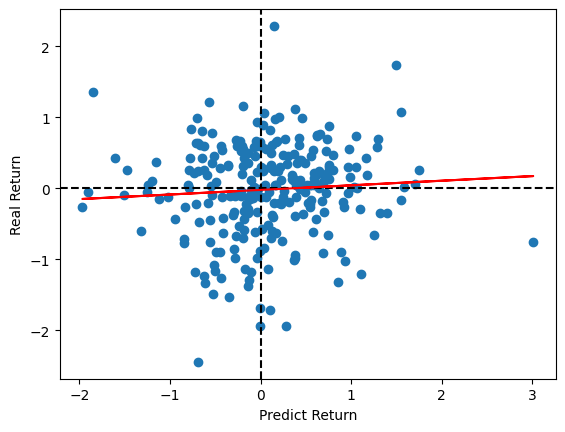

In [79]:
## values
# df = df_clean.copy()
df = (df_clean - df_clean.mean())/df_clean.std()
ratio = 0.7
if select == lead_factor:
    for i in range(len(lead_factor)):
        item = lead_factor[i]
        days = lead_factor_days[i]
        df[item] = df[item].shift(int(days))
elif select == lead_factor_dir:
    for i in range(len(lead_factor_dir)):
        item = lead_factor_dir[i]
        days = lead_factor_dir_days[i]
        df[item] = df[item].shift(int(days))
df = df.dropna()
df_train = df.iloc[:int(len(df)*ratio)]
df_test = df.iloc[int(len(df)*ratio):]
x_train = df_train[select]
x_test = df_test[select]

y_train = df_train['y']
y_test = df_test['y']

# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# xgboostModel = XGBRegressor(max_depth = 60,n_estimators=300, learning_rate=2).fit(x_train,y_train)
# predicted = xgboostModel.predict(x_test)
xgboostModel1 = XGBRegressor(max_depth = 1,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted1 = xgboostModel1.predict(x_test)
xgboostModel2 = XGBRegressor(max_depth = 1,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted2 = xgboostModel2.predict(x_test)
xgboostModel3 = XGBRegressor(max_depth = 7,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted3 = xgboostModel3.predict(x_test)
xgboostModel4 = XGBRegressor(max_depth = 2,n_estimators=600, learning_rate=2).fit(x_train,y_train)
predicted4 = xgboostModel4.predict(x_test)
# xgboostModel5 = XGBRegressor(max_depth = 6,n_estimators=600, learning_rate=2).fit(x_train,y_train)
# predicted5 = xgboostModel5.predict(x_test)
predicted = (predicted1+predicted2+predicted3+predicted4)/5
df_boost = pd.DataFrame({'y':y_test,'predict':predicted})
draw_distribution(df_boost)
confusion_matrix(df_boost)

#### Regression

In [80]:
# ## value
# if select == lead_factor:
#     for i in range(len(lead_factor)):
#         item = lead_factor[i]
#         days = lead_factor_days[i]
#         df[item] = df[item].shift(int(days))
# elif select == lead_factor_dir:
#     for i in range(len(lead_factor_dir)):
#         item = lead_factor_dir[i]
#         days = lead_factor_dir_days[i]
#         df[item] = df[item].shift(int(days))
# df['y'] = df_clean['y']
# df_reg = df.dropna()
# time_units = 60

# for i in range(len(df_reg)-time_units):
#     today = df_reg.iloc[i+time_units].name
#     next_day = df_reg.loc[today:].head(2).index[-1]
#     ## 固定取值    
#     # duration = df_reg.iloc[i:i+time_units]
#     ## 累加取值
#     duration = df_reg.loc[:today]
#     # duration = (duration - duration.mean())/duration.std()

#     Y = duration['y']
#     X = duration[select]
#     model = sm.OLS(Y,sm.add_constant(X)).fit()
#     df_reg.loc[next_day,'R-Square'] = model.rsquared*100
#     predict=0
#     try:
#         df_reg.loc[next_day,'const'] = model.params.const
#         predict+=df_reg.loc[next_day,'const']
#     except:
#         df_reg.loc[next_day,'const'] = np.nan
    
#     for j in select:
#         df_reg.loc[next_day,j+' coef'] = model.params[j]
#         predict += (df_reg.loc[next_day,j])*(df_reg.loc[next_day,j+' coef'])
#         # predict += (duration[j].mean())*df_reg.loc[next_day,j+'coef']
#     df_reg.loc[next_day,'predict'] = predict 
# df_reg
# draw_distribution(df_reg)
# confusion_matrix(df_reg)

#### LSTM

In [81]:
# ## value
# ratio = 0.7
# df = df_clean.copy()
# if select == lead_factor:
#     for i in range(len(lead_factor)):
#         item = lead_factor[i]
#         days = lead_factor_days[i]
#         df[item] = df[item].shift(int(days))
# elif select == lead_factor_dir:
#     for i in range(len(lead_factor_dir)):
#         item = lead_factor_dir[i]
#         days = lead_factor_dir_days[i]
#         df[item] = df[item].shift(int(days))
# df['y'] = df['y']
# df = df.dropna()
# df_train = df.iloc[:int(len(df)*ratio)]
# df_test = df.iloc[int(len(df)*ratio):]
# x_train = np.array(df_train[select])
# x_test = np.array(df_test[select])

# y_train = np.array(df_train['y'])
# y_test = np.array(df_test['y'])
# print(f'n of x train :{x_train.shape}')
# print(f'n of y train :{y_train.shape}')
# print(f'n of x train :{x_test.shape}')
# print(f'n of y train :{y_test.shape}')

# FullData = df[select]
# # FullData.replace([np.inf, -np.inf], np.nan, inplace=True) 
# # FullData.dropna(inplace=True) 
# FullDataY = df['y'].values
# FullData = FullData.values

# # sc = StandardScaler()
# sc=MinMaxScaler()
# DataScaler = sc.fit(FullData)
# X=DataScaler.transform(FullData)
# DataScalerY = sc.fit(FullDataY.reshape(-1, 1))
# Y=DataScalerY.transform(FullDataY.reshape(-1, 1))
# # X.replace([np.inf, -np.inf], np.nan, inplace=True) 
# # X.dropna(inplace=True) 
 
# print('### After Normalization ###')
# print(X.shape)
# print(Y.shape)

# X_samples = list()
# y_samples = list()
 
# NumerOfRows = len(X)
# TimeSteps=60  # next day's Price Prediction is based on last how many past day's prices
 
# # Iterate thru the values to create combinations
# for i in range(TimeSteps , NumerOfRows , 1):
#     x_sample = X[i-TimeSteps:i]
#     y_sample = Y[i]
#     X_samples.append(x_sample)
#     y_samples.append(y_sample)

# # Reshape the Input as a 3D (number of samples, Time Steps, Features)
# X_data=np.array(X_samples)
# X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], X.shape[1])
# print('\n#### Input Data shape ####')
# print(X_data.shape)
 
# y_data=np.array(y_samples)
# y_data=y_data.reshape(y_data.shape[0], 1)
# print('\n#### Output Data shape ####')
# print(y_data.shape)

# TestingRecords=300
# X_train=X_data[:-TestingRecords]
# X_test=X_data[-TestingRecords:]
# y_train=y_data[:-TestingRecords]
# y_test=y_data[-TestingRecords:]
 
# # Printing the shape of training and testing
# print('\n#### Training Data shape ####')
# print(X_train.shape)
# print(y_train.shape)
# print('\n#### Testing Data shape ####')
# print(X_test.shape)
# print(y_test.shape)

# # Defining Input shapes for LSTM
# TimeSteps=X_train.shape[1]
# TotalFeatures=X_train.shape[2]
# print("Number of TimeSteps:", TimeSteps)
# print("Number of Features:", TotalFeatures)
 
# # Initialising the RNN
# regressor = Sequential()
# regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
# regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
# regressor.add(Dense(units = 1))
# regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

# TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
# TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
# print(len(TrainPredictions),len(TestPredictions))
 
# FullDataPredictions=np.append(TrainPredictions, TestPredictions)
# FullDataOrig=FullDataY[TimeSteps:]

# plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted')
# plt.plot(FullDataOrig , color = 'lightblue', label = 'Original')
 
 
# plt.title('Predictions')
# plt.xlabel('Trading Date')
# plt.ylabel('pct')
# plt.legend()
# fig=plt.gcf()
# fig.set_figwidth(20)
# fig.set_figheight(8)
# plt.show()

# df_lstm = pd.DataFrame({'y':[i for i in FullDataY[-300:].tolist()],'predict':[i[0] for i in TestPredictions.tolist()]})
# draw_distribution(df_lstm)
# confusion_matrix(df_lstm)

In [82]:
df_boost['real_y'] = df_clean['y']
abnormal = df_boost[abs(df_boost['real_y'])>0.01]
normal = df_boost[abs(df_boost['real_y'])<=0.01]
print(len(abnormal),len(normal))
accuracy_ab = (len(abnormal[abnormal['accuracy']=='TP'])+len(abnormal[abnormal['accuracy']=='TN']))/len(abnormal)
accuracy = (len(normal[normal['accuracy']=='TP'])+len(normal[normal['accuracy']=='TN']))/len(normal)
print(f'Accuracy of abnormal: {accuracy_ab}')
print(f'Accuracy of normal: {accuracy}')

55 207
Accuracy of abnormal: 0.6363636363636364
Accuracy of normal: 0.5700483091787439


In [83]:
abnormal[abnormal['predict_signal']==abnormal['real_signal']][['y','predict']]

,y,predict
Date,,
2023-06-27,0.877535,0.756374
2023-07-20,-1.177577,-0.720276
2023-07-27,-1.163880,-0.503016
2023-08-09,-0.892828,-0.491548
2023-08-17,-1.269635,-0.434555
2023-08-23,1.118807,0.379846
2023-08-24,-2.445764,-0.696176
2023-08-29,1.743526,1.496502
2023-09-15,-1.174605,-0.105815


In [84]:
print(len(normal),len(abnormal))

207 55


In [85]:
normal[normal['predict_signal']==normal['real_signal']][['y','predict']]

,y,predict
Date,,
2023-07-03,0.044838,0.387873
2023-07-06,0.214077,0.589145
2023-07-07,-0.102275,-0.277575
2023-07-10,0.185457,0.704933
2023-07-11,0.130473,0.350754
...,...,...
2024-06-26,0.243993,0.024613
2024-06-27,0.123344,0.359497
2024-06-28,-0.601239,-1.316403
